In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import sys
import os

project_path = '/content/drive/My Drive/ICON'
src_path = os.path.join(project_path, 'src')

if src_path not in sys.path:
    sys.path.append(src_path)
try:
    os.chdir(project_path)
except FileNotFoundError:
    print(f"cartella non trovata")

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from loader_dati import carica_e_pulisci_dati
from eda import esegui_eda_base, traccia_distribuzioni
from preprocessing import preprocessa_dati
from clustering import trova_k_ottimale, applica_kmeans_e_aggiungi_feature
from modelli import ottieni_modelli, ottieni_griglie_parametri
from valutazioni import ottimizza_e_valuta_modelli_cv, stampa_risultati_cv

warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)

In [ ]:
PERCORSO_FILE_CSV = 'dataset/heart-disease/heart_disease_uci.csv'
COLONNA_TARGET = 'target'
NUM_SPLIT_ESTERNI = 10
NUM_SPLIT_INTERNI = 5  #tuning iperparametri
MAX_K_CLUSTERING = 8
STATO_CASUALE = 42
K_OTTIMALE = 4         # verificato tramite il metodo elbow

In [ ]:

df_dati = carica_e_pulisci_dati(PERCORSO_FILE_CSV)
if df_dati is not None:
    print("\nprime righe dati puliti:")
    print(df_dati.head())
    print("\ninfo dati puliti:")
    df_dati.info()
else:
    print("loead e pulizia falliti.")

convertita 'sex' in numerico 0/1.

valori mancanti prima 
trestbps     59
chol         30
fbs          90
thalch       55
exang        55
oldpeak      62
ca          611
dtype: int64

verifica dopo pulizia
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 920 entries, 0 to 919
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       920 non-null    int64  
 1   sex       920 non-null    int64  
 2   cp        920 non-null    object 
 3   trestbps  920 non-null    float64
 4   chol      920 non-null    float64
 5   fbs       920 non-null    float64
 6   restecg   920 non-null    object 
 7   thalch    920 non-null    float64
 8   exang     920 non-null    float64
 9   oldpeak   920 non-null    float64
 10  slope     920 non-null    object 
 11  ca        920 non-null    float64
 12  thal      920 non-null    object 
 13  target    920 non-null    int64  
dtypes: float64(7), int64(3), object(4)
memory usage: 100.8+ KB



dati inziali:
   age  sex                cp  trestbps   chol  fbs            restecg  \
0   63    1   typical angina      145.0  233.0  1.0   lv hypertrophy     
1   67    1   asymptomatic        160.0  286.0  0.0   lv hypertrophy     
2   67    1   asymptomatic        120.0  229.0  0.0   lv hypertrophy     
3   37    1   non-anginal         130.0  250.0  0.0   normal             
4   41    0   atypical angina     130.0  204.0  0.0   lv hypertrophy     

   thalch  exang  oldpeak         slope   ca               thal  target  
0   150.0    0.0      2.3   downsloping  0.0       fixed defect       0  
1   108.0    1.0      1.5   flat         3.0             normal       1  
2   129.0    1.0      2.6   flat         2.0  reversable defect       1  
3   187.0    0.0      3.5   downsloping  0.0             normal       0  
4   172.0    0.0      1.4   upsloping    0.0             normal       0  

info dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 920 entries, 0 to 919
Data colum

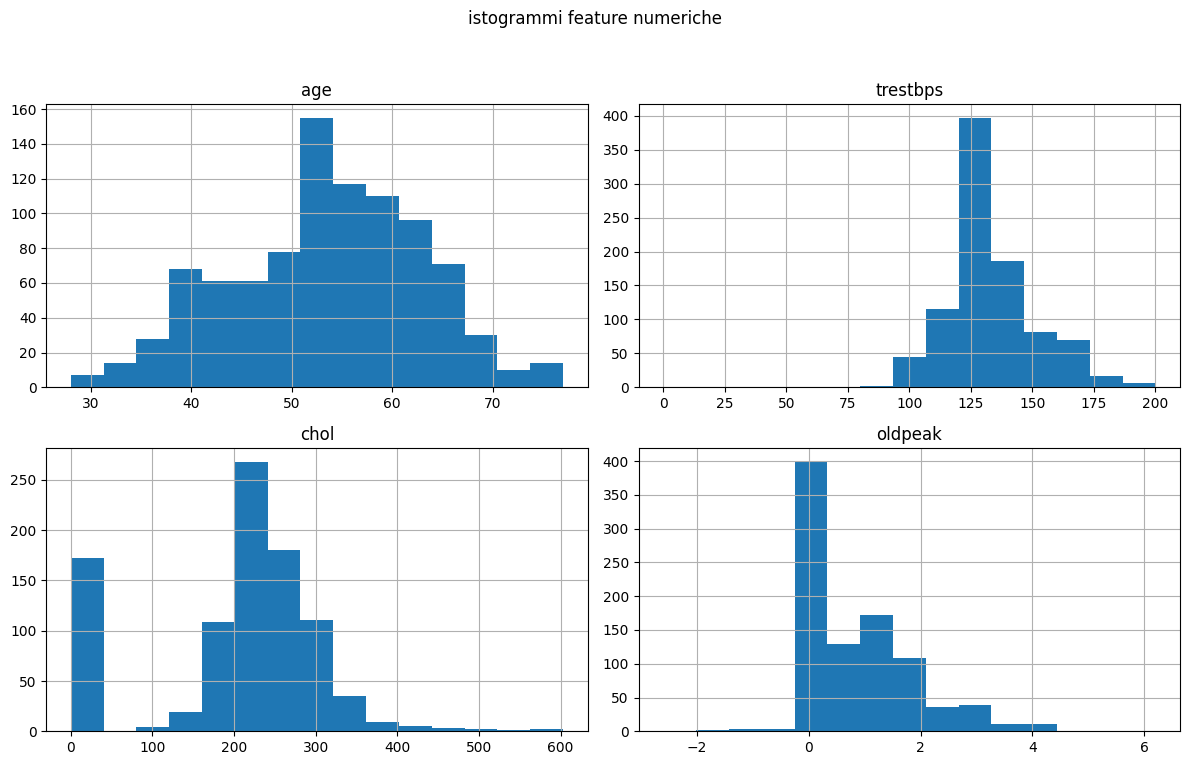

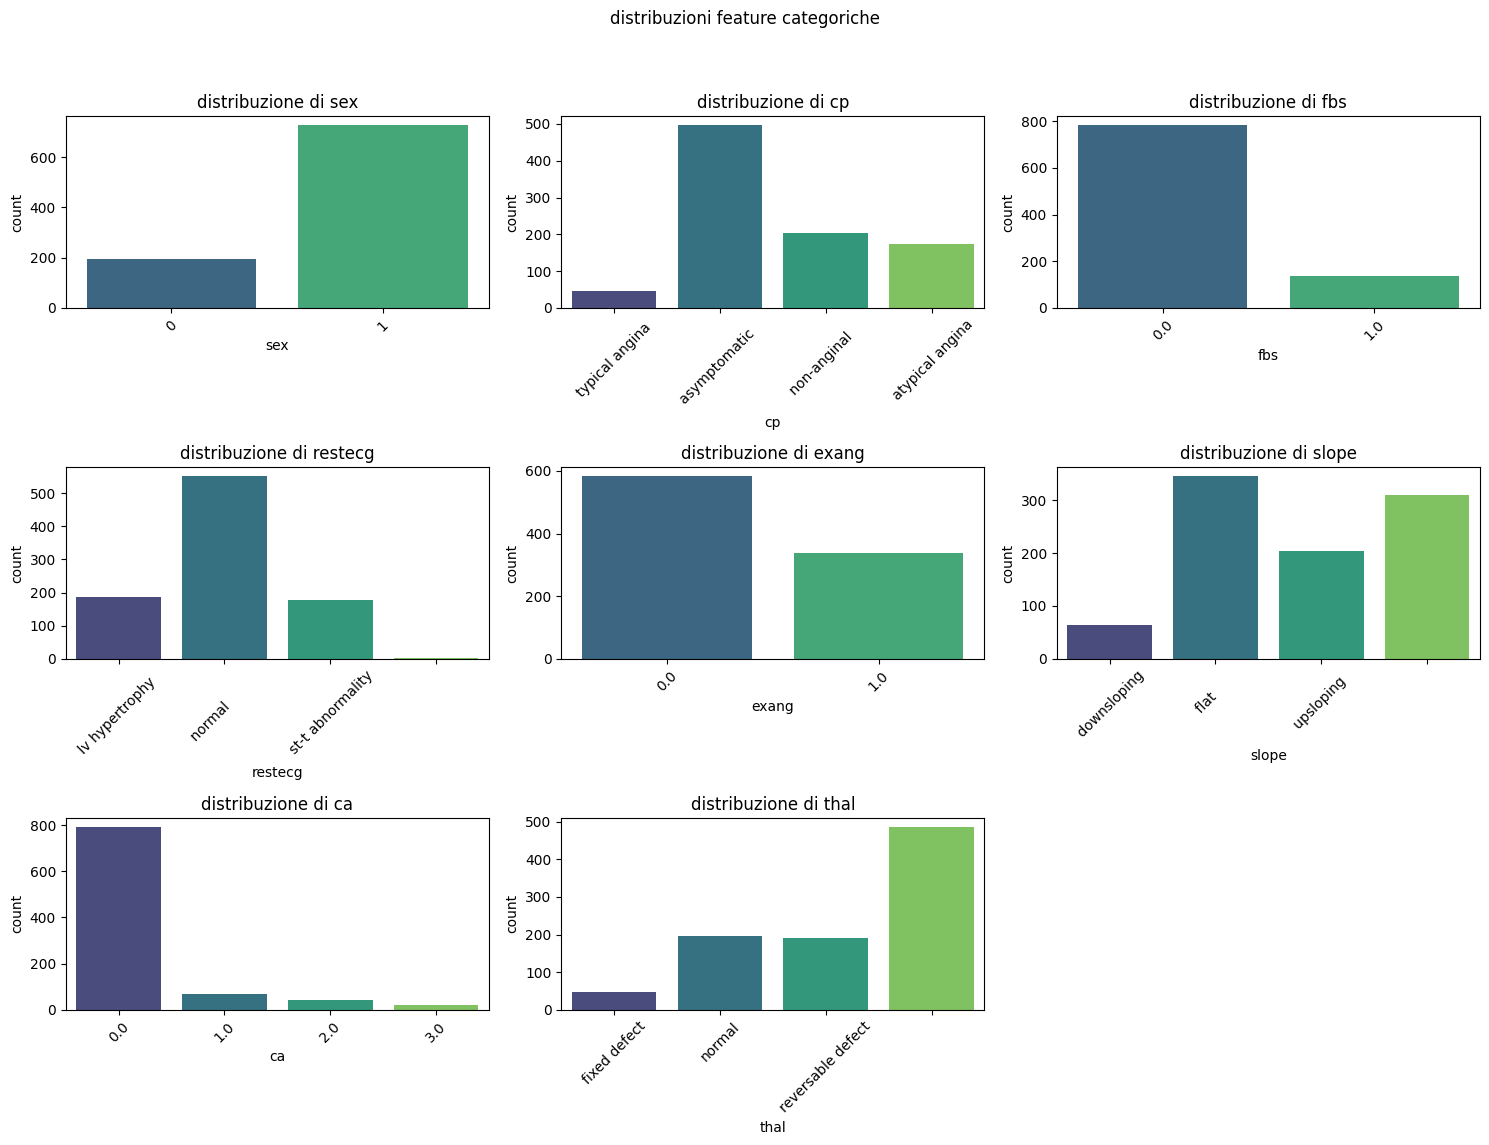

In [ ]:
if df_dati is not None:
    esegui_eda_base(df_dati)
    traccia_distribuzioni(df_dati)
else:
    print("load fallito")

In [ ]:
 #preprocessing Iniziale (no cluster)
X_proc_no_cluster, y_target, preprocessore_no_cluster, nomi_feature_no_cluster = None, None, None, None
if df_dati is not None:
    X_proc_no_cluster, y_target, preprocessore_no_cluster, nomi_feature_no_cluster = preprocessa_dati(df_dati.copy(), COLONNA_TARGET)
else:
    print("errore caricamento, preprocessing saltato")


if X_proc_no_cluster is not None:
    try:
        print("\nprime righe dati processati (senza cluster):")
        print(pd.DataFrame(X_proc_no_cluster, columns=nomi_feature_no_cluster).head())
    except ValueError:
         print("impossibile mostrare dataframe preprocessato.")


prime righe dati processati (senza cluster):
        age  trestbps      chol    thalch   oldpeak  cp_ asymptomatic     \
0  1.007386  0.705176  0.303643  0.462879  1.368109                  0.0   
1  1.432034  1.518569  0.789967 -1.197349  0.611589                  1.0   
2  1.432034 -0.650479  0.266939 -0.367235  1.651804                  1.0   
3 -1.752828 -0.108217  0.459634  1.925460  2.502889                  0.0   
4 -1.328180 -0.108217  0.037541  1.332522  0.517024                  0.0   

   cp_ atypical angina  cp_ non-anginal      cp_ typical angina   \
0                  0.0                  0.0                  1.0   
1                  0.0                  0.0                  0.0   
2                  0.0                  0.0                  0.0   
3                  0.0                  1.0                  0.0   
4                  1.0                  0.0                  0.0   

   restecg_                   ...  ca_1.0  ca_2.0  ca_3.0  thal_  \
0                   


ricerca del k Ottimale


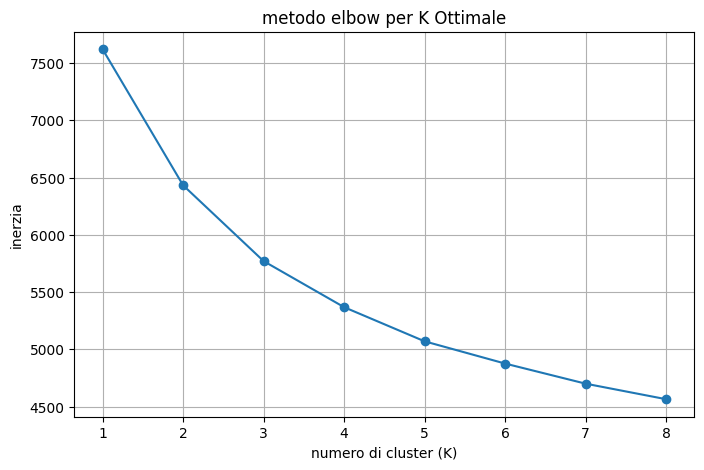

In [ ]:
# Per trovare il K ottimale
if X_proc_no_cluster is not None:
    trova_k_ottimale(X_proc_no_cluster, max_k=MAX_K_CLUSTERING, stato_casuale=STATO_CASUALE)
else:
    print("clustering saltato errore preprocessing.")

In [ ]:
# applicazione k-means e feature con cluster
X_proc_con_cluster, preprocessore_con_cluster, nomi_feature_con_cluster = None, None, None
if X_proc_no_cluster is not None and df_dati is not None:
    X_proc_con_cluster, preprocessore_con_cluster, nomi_feature_con_cluster = applica_kmeans_e_aggiungi_feature(
        df_dati.drop(COLONNA_TARGET, axis=1),
        X_proc_no_cluster,
        K_OTTIMALE,
        stato_casuale=STATO_CASUALE
    )
else:
    print("feature cluster saltata.")

if X_proc_con_cluster is not None:
    try:
        print("\nrighe dati processati (cluster):")
        print(pd.DataFrame(X_proc_con_cluster, columns=nomi_feature_con_cluster).head())
    except ValueError:
        print("impossibile mostrare dataframe con cluster")


applicazione k-means, k=4
aggiunta feature 'cluster' (K=4)

righe dati processati (cluster):
        age  trestbps      chol    thalch   oldpeak  cp_ asymptomatic     \
0  1.007386  0.705176  0.303643  0.462879  1.368109                  0.0   
1  1.432034  1.518569  0.789967 -1.197349  0.611589                  1.0   
2  1.432034 -0.650479  0.266939 -0.367235  1.651804                  1.0   
3 -1.752828 -0.108217  0.459634  1.925460  2.502889                  0.0   
4 -1.328180 -0.108217  0.037541  1.332522  0.517024                  0.0   

   cp_ atypical angina  cp_ non-anginal      cp_ typical angina   \
0                  0.0                  0.0                  1.0   
1                  0.0                  0.0                  0.0   
2                  0.0                  0.0                  0.0   
3                  0.0                  1.0                  0.0   
4                  1.0                  0.0                  0.0   

   restecg_                   ...  thal_

In [ ]:
#modelli e grid
tutti_i_modelli = ottieni_modelli(stato_casuale=STATO_CASUALE)
griglie_parametri = ottieni_griglie_parametri()

modello_nb = {'Naive Bayes': tutti_i_modelli['Naive Bayes']}
modelli_standard = {nome: modello for nome, modello in tutti_i_modelli.items() if nome != 'Naive Bayes'}
griglie_standard = {nome: griglia for nome, griglia in griglie_parametri.items() if nome in modelli_standard}

print("Modelli e griglie definiti.")
print("Modelli Standard:", list(modelli_standard.keys()))
print("Griglie Standard:", griglie_standard)

Modelli e griglie parametri definiti.
Modelli Standard: ['Regressione Logistica', 'Albero Decisionale', 'SVM']
Griglie Standard: {'Regressione Logistica': {'C': [0.01, 0.1, 1, 10, 100]}, 'Albero Decisionale': {'max_depth': [None, 5, 10, 15], 'min_samples_leaf': [1, 5, 10]}, 'SVM': {'C': [0.1, 1, 10], 'gamma': ['scale', 'auto', 0.1, 1]}}


In [ ]:
#valutazione Naive Bayes senza cluster
print("\nvalutazione NB")
risultati_nb = None
if X_proc_no_cluster is not None and y_target is not None:
    risultati_nb = ottimizza_e_valuta_modelli_cv(
        modello_nb, {}, X_proc_no_cluster, y_target,
        num_split_esterni=NUM_SPLIT_ESTERNI, num_split_interni=NUM_SPLIT_INTERNI, stato_casuale=STATO_CASUALE
    )
else:
    print("valutazione NB saltata.")


valutazione NB
tuning-valutazione Naive Bayes...
no griglia parametri per Naive Bayes -> valutazione semplice
valutazione semplice Naive Bayes completata.


In [ ]:
#valutazione modelli normali senza cluster
print("valutazione modelli normali senza cluster")
risultati_no_cluster = None
if X_proc_no_cluster is not None and y_target is not None:
    risultati_no_cluster = ottimizza_e_valuta_modelli_cv(
        modelli_standard, griglie_standard, X_proc_no_cluster, y_target,
        num_split_esterni=NUM_SPLIT_ESTERNI, num_split_interni=NUM_SPLIT_INTERNI, stato_casuale=STATO_CASUALE
    )
else:
    print("valutazione modelli normali senza cluster")

valutazione modelli normali senza cluster
tuning-valutazione Regressione Logistica...
tuning-valutazione Regressione Logistica ok.
tuning-valutazione Albero Decisionale...
tuning-valutazione Albero Decisionale ok.
tuning-valutazione SVM...
tuning-valutazione SVM ok.


In [ ]:
#valutazione modelli normali con cluster
print("valutazione modelli normali con cluster")
risultati_con_cluster = None
if X_proc_con_cluster is not None and y_target is not None:

    modelli_standard_clust = ottieni_modelli(stato_casuale=STATO_CASUALE)
    modelli_standard_clust = {nome: modello for nome, modello in modelli_standard_clust.items() if nome != 'Naive Bayes'}

    risultati_con_cluster = ottimizza_e_valuta_modelli_cv(
        modelli_standard_clust, griglie_standard, X_proc_con_cluster, y_target,
        num_split_esterni=NUM_SPLIT_ESTERNI, num_split_interni=NUM_SPLIT_INTERNI, stato_casuale=STATO_CASUALE
    )
else:
    print("valutazione modelli normali con cluster saltata")

valutazione modelli normali con cluster
tuning-valutazione Regressione Logistica...
tuning-valutazione Regressione Logistica ok.
tuning-valutazione Albero Decisionale...
tuning-valutazione Albero Decisionale ok.
tuning-valutazione SVM...
tuning-valutazione SVM ok.


In [ ]:
#riepilogo risultati
print("riepilogo risultati")
risultati_finali_combinati = {}
if risultati_nb:
    risultati_finali_combinati.update(risultati_nb)
if risultati_no_cluster:
    risultati_finali_combinati.update(risultati_no_cluster)
if risultati_con_cluster:
    for nome_modello, dati_ris in risultati_con_cluster.items():
        nome_nuovo = nome_modello.replace(" (Tuned)", " + Clust (Tuned)") if " (Tuned)" in nome_modello else nome_modello + " + Clust"
        risultati_finali_combinati[nome_nuovo] = dati_ris

if risultati_finali_combinati:
    df_risultati_finali = stampa_risultati_cv(risultati_finali_combinati)
    df_risultati_finali.to_csv('riepilogo_risultati_progetto.csv')
else:
    print("nessun risultato")

riepilogo risultati

modello: Naive Bayes
  accuracy: 0.6880 (+/- 0.0571)
  precision: 0.8985 (+/- 0.0575)
  recall: 0.4976 (+/- 0.1215)
  f1: 0.6300 (+/- 0.0940)
  roc_auc: 0.8725 (+/- 0.0435)

modello: Regressione Logistica (Tuned)
  accuracy: 0.8283 (+/- 0.0370)
  precision: 0.8362 (+/- 0.0302)
  recall: 0.8586 (+/- 0.0586)
  f1: 0.8462 (+/- 0.0356)
  roc_auc: 0.8915 (+/- 0.0274)

modello: Albero Decisionale (Tuned)
  accuracy: 0.7804 (+/- 0.0360)
  precision: 0.8018 (+/- 0.0535)
  recall: 0.8095 (+/- 0.0531)
  f1: 0.8031 (+/- 0.0309)
  roc_auc: 0.8431 (+/- 0.0394)

modello: SVM (Tuned)
  accuracy: 0.8326 (+/- 0.0330)
  precision: 0.8254 (+/- 0.0273)
  recall: 0.8862 (+/- 0.0642)
  f1: 0.8533 (+/- 0.0329)
  roc_auc: 0.9024 (+/- 0.0272)

modello: Regressione Logistica + Clust (Tuned)
  accuracy: 0.8272 (+/- 0.0297)
  precision: 0.8431 (+/- 0.0299)
  recall: 0.8468 (+/- 0.0573)
  f1: 0.8436 (+/- 0.0299)
  roc_auc: 0.8969 (+/- 0.0283)

modello: Albero Decisionale + Clust (Tuned)
  accu